# Group B: VaR assignment | Data Engineering
### Group members:
* Alexander Verresen
* Borja Pérez
* Giuseppe Pepe
* Iurii Fedotov

In [1]:
import csv
import pandas as pd
import numpy as np
import urllib.request as url
import time
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1. Import of data from APIs to .csv file for further access

In [2]:
def get_symbols_from_txt():
    """This function reads the text file with symbols and returns a list of them"""
    
    with open("Symbols.txt") as data:                                                                                          
    
        data_reader = csv.reader(data)
        # By default, each new line is read as a list with 1 element, so we need to access it.
        symbols = [symbol[0] for symbol in data_reader]
        
        return symbols

symbols = get_symbols_from_txt()

def get_stock_adjusted_price_dataframe(symbol):
    """This function returns a dataframe with 2 columns - date and all-time adjusted close price
    for any stock ticker supplied as a parameter.
    We use adjusted close price, not nominal close price, to take splits into account."""
    
    # Store the URL with 1 parameter which will change – the symbol.
    url_for_stock = ('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize=full&apikey=CAJH46WI0QYW2RGK&datatype=csv').format(symbol)
    # Open the URL and retrieve raw data from there – it will include many columns
    raw_data_retrieved = url.urlopen(url_for_stock)
    clean_data_retrieved = raw_data_retrieved.read().decode('ascii').splitlines()
    
    # Set up a dictionary to store the data we need
    single_asset_dictionary = {
        'date': [],
        symbol: []
    }
    
    # Iterate over the rows recieved, and add only the date and adj. close price for each day
    for day in clean_data_retrieved[1:]:
        day_as_list = day.split(',')
        single_asset_dictionary['date'].append(day_as_list[0]) # Dates are presented as the first element
        single_asset_dictionary[symbol].append(day_as_list[5]) # The price we need in the sixth element in each list
    
    # Convert the dictionary to a dataframe
    stock_adjusted_price_dataframe = pd.DataFrame(single_asset_dictionary)
    
    return stock_adjusted_price_dataframe

def get_oil_price():
    """This function returns the dataframe with 2 columns - date and oil price"""
    
    # Retrieve data and store it as a list of strings
    oil_url = ('https://www.quandl.com/api/v3/datasets/OPEC/ORB/data.csv?start_date=2007-12-20&end_date=2019-02-10&api_key=LwmAyD-1JHAzhMKKSvDX')
    oil_raw_data_retrieved = url.urlopen(oil_url)
    oil_clean_data_retrieved = oil_raw_data_retrieved.read().decode('ascii').splitlines()
    
    # Set up a dictionary to store the data we need
    oil_dictionary = {
            'date': [],
            'oil_price': []
        }
    
    # Iterate over the rows recieved, and add the data to the dictionary
    for day in oil_clean_data_retrieved[1:]:
        day_as_list = day.split(',')
        oil_dictionary['date'].append(day_as_list[0]) # Dates are presented as the first element
        oil_dictionary['oil_price'].append(day_as_list[1]) # The price we need in the second element in each list
    
    # Convert the dictionary to a dataframe
    oil_price_dataframe = pd.DataFrame(oil_dictionary)
    
    return oil_price_dataframe

def get_tbonds_rate():
    """This function returns the dataframe with 2 columns - date and 10Y tbonds rate.
    We use the 10-Year bond, because it is the first security in the world in terms of trading volume.
    In addition, bonds with shorter maturity by definition to not fluctuate much according to the mood
    in the stock market, because their principal payment comes soon."""
    
    # Retrieve data and store it as a list of strings
    tbonds_url = ('https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.csv?start_date=2007-12-20&end_date=2019-02-10&api_key=LwmAyD-1JHAzhMKKSvDX')
    tbonds_raw_data_retrieved = url.urlopen(tbonds_url)
    tbonds_clean_data_retrieved = tbonds_raw_data_retrieved.read().decode('ascii').splitlines()
    
    # Set up a dictionary to store the data we need
    tbonds_dictionary = {
            'date': [],
            'tbonds_rate': []
        }
    
    # Iterate over the rows recieved, and add the data to the dictionary
    for day in tbonds_clean_data_retrieved[1:]:
        day_as_list = day.split(',')
        tbonds_dictionary['date'].append(day_as_list[0]) # Dates are presented as the first element
        tbonds_dictionary['tbonds_rate'].append(day_as_list[10]) # The rate we need in the 10th element in each list
    
    # Convert the dictionary to a dataframe
    tbonds_rate_dataframe = pd.DataFrame(tbonds_dictionary)
    
    return tbonds_rate_dataframe

def prepare_dataframe_with_all_prices(symbols):
    """This function accepts a list of symbols, and uploads the data for all symbols presented
    in the list supplied. It also adds 4 macro variables which we are interested in: NASDAQ index, S&P500 index,
    oil prices and treasuries bonds rate. It returns a dataframe with a complete information
    needed in the next parts of the assignments.
    
    First, it uploads the values of NASDAQ index from a local .csv file, which we imported from Yahoo Finance.
    VERY IMPORTANT: the ticker "NDAQ" is not the NASDAQ index!
    It's a ticker of the stock of NASDAQ stock exchange as a corporation. Unfortunately, the NASDAQ index is not
    available at Alpha Vantage API, we checked it in many forums and many people reported this issue.
    """
    
    # IXIC is the official ticker of NASDAQ composite index. We upload it from a local file.
    ixic = pd.read_csv('^IXIC.csv', usecols = ['Date','Adj Close']) \
    .rename(columns = {'Date':'date','Adj Close':'IXIC'})
    
    # Make a copy of the dataframe above, and this copy will serve as a container to store all the data.
    overall_df = ixic.copy()
    
    # Since the data import takes several minutes, we need logs to control the process.
    # These 2 variables will help to calculate how many of the requested symbols
    # were found in the API endpoint and uploaded.
    total_symbols_provided = len(symbols)
    symbols_successfully_uploaded = 0
    
    # For each symbol...
    for symbol in symbols:
        
        print('Started processing {}'.format(symbol))
        
        # Try to access the API endpoint corresponding to this symbol and upload the data
        try:
            df_for_symbol = get_stock_adjusted_price_dataframe(symbol)
            # Merge the uploaded data as a LEFT join on data to the values of NASDAQ that we have.
            overall_df = overall_df.merge(df_for_symbol, how = 'left', on = 'date')
            print('{} added successfully'.format(symbol))
            symbols_successfully_uploaded += 1
            # Important! To avoid high load on API and potential ban of the key, we force a 15-second delay
            # between each two securities.
            time.sleep(15)
        
        # If a given symbol is not found in the API endpoint, print it to logs and process with next symbol.
        except:
            print('Symbol {} does not exit'.format(symbol))
            pass
        
        print('-----')
    
    # Provide the import statistics: how many symbols were successfully uploaded.
    print('{} symbols out of {} from the txt file successfully uploaded'.format(symbols_successfully_uploaded, total_symbols_provided))
    
    # Use functions defined above to get the 3 left macro features
    oil_price = get_oil_price()
    tbonds_rate = get_tbonds_rate()
    gspc = get_stock_adjusted_price_dataframe('^GSPC')

    # Add them all to the main dataframe containing all data
    for market_index in [oil_price, tbonds_rate, gspc]:
        overall_df = overall_df.merge(market_index, how = 'left', on = 'date')
        
    print('Oil prices, tbonds rate and S&P500 index values successfully uploaded')
        
    overall_df.rename(columns={'IXIC':'nasdaq','^GSPC':'sp500'}, inplace=True)
    
    return overall_df

def save_dataframe_from_apis_to_csv(dataframe):
    """This function takes a dataframe and saves it locally."""
    
    dataframe.to_csv('./all_data_from_apis.csv', header = True, index = False)

## Step 2. Preprocessing the data for models
### 2.1. Import the .csv file with stocks prices and macro factors values
**VERY IMPORTANT:** the Symbols.txt file contained 50 symbols of stocks. However, only 34 of them were available in the API service. For those which are not there, even the Yahoo Finance pages do not exist, which means that these stock are either traded on low-tier local exchanges, or there are typos in the Symbols.txt. **We included 34 stocks in our portfolio (only those for which we managed to get the data from the API)**, and followed the rule of assuming 1 unit of each stock in the portfolio.

In [3]:
all_data_prices = pd.read_csv('all_data_from_apis.csv', parse_dates = ['date'], index_col = 'date')
print('All factors and stocks prices:')
display(all_data_prices)

All factors and stocks prices:


,nasdaq,PIH,FLWS,FCCY,SRCE,FUBC,VNET,TWOU,DGLD,JOBS,...,DJCO,SATS,WATT,INBK,FTLB,QABA,GOOG,oil_price,tbonds_rate,sp500
date,,,,,,,,,,,,,,,,,,,,,
2007-12-20,2640.860107,NaN,8.95,7.6362,12.0800,NaN,NaN,NaN,NaN,9.525,...,41.25,NaN,NaN,8.1369,NaN,NaN,NaN,87.36,4.04,1460.1200
2007-12-21,2691.989990,NaN,8.94,7.4259,12.1397,NaN,NaN,NaN,NaN,9.425,...,41.25,NaN,NaN,8.1369,NaN,NaN,NaN,87.73,4.18,1484.4600
2007-12-24,2713.500000,NaN,9.06,7.4522,12.0800,NaN,NaN,NaN,NaN,9.630,...,41.25,NaN,NaN,8.1369,NaN,NaN,NaN,87.86,4.23,1496.4500
2007-12-26,2724.409912,NaN,8.83,8.0934,12.6906,NaN,NaN,NaN,NaN,9.720,...,41.25,NaN,NaN,8.1369,NaN,NaN,NaN,89.44,4.30,1497.6600
2007-12-27,2676.790039,NaN,8.70,7.7518,11.7415,NaN,NaN,NaN,NaN,9.370,...,41.25,NaN,NaN,8.2290,NaN,NaN,NaN,90.29,4.21,1476.2700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-29,7028.290039,4.3499,13.28,19.1600,44.0998,NaN,8.83,56.10,43.97,66.310,...,216.12,20.3299,7.68,19.7137,20.2738,47.0689,1060.62,59.71,2.72,2640.0000
2019-01-30,7183.080078,4.3100,13.34,19.2579,44.2164,NaN,8.74,56.57,43.23,66.690,...,222.30,20.3248,7.40,19.5555,20.3497,46.8534,1089.06,60.93,2.70,2681.0500
2019-01-31,7281.740234,4.4600,15.95,19.0229,44.0998,NaN,8.98,56.85,43.16,69.640,...,221.11,20.8488,7.46,19.7730,20.4947,46.4421,1116.37,61.19,2.63,2704.1001


### 2.2. Check the NaN values by column
**Findings:** some columns contained NaNs, but even for worst of them, NaNs were ~56% of the total observations.

**Decision:**
* In macro factors, all NaNs were surrounded by true values, thus giving us an opportunity to **interpolate the NaNs**. And that was what we did.
* In stocks, all NaNs were outside of the true values - for example, when the stock was not public yet, or when it stopped being traded for some reason. Therefore, we cannot interpolate missing values. Taking into account that all stocks have at least 1,000 real values of price, we decided **leave NaNs as they are and train a model for each stock only on the data which has true values for this stock.** Filling NaNs with some guessed values seems worse than reducing the dataset size from 2,800 observations to, in the worst case, 1,300. Even 1,300 observations is more then enough to build a linear regression with a few features.

In [4]:
def list_columns_with_nans_and_their_count(dataframe):
    """This funciton returns a sorted pandas series with columns which have
    null values, and the %% of these values respectively."""
    
    nans_counter = (dataframe.isna().sum() / len(dataframe)).sort_values(ascending = False)
    return nans_counter[nans_counter > 0]

print('Proportions of emply values before filling them:')
print(list_columns_with_nans_and_their_count(all_data_prices))

for column in ['tbonds_rate', 'oil_price']:
    all_data_prices[column].interpolate(inplace = True, limit_area = 'inside')

print('')
print('Proportions of emply values after filling those for macro factors:')
print(list_columns_with_nans_and_their_count(all_data_prices))

Proportions of emply values before filling them:
PIH            0.564130
WATT           0.563416
TWOU           0.563416
GOOG           0.563058
FTLB           0.543408
FUBC           0.417292
MTGE           0.361915
DGLD           0.344051
VNET           0.300107
CHOP           0.286531
HTHT           0.203287
QABA           0.137192
HGSH           0.022151
tbonds_rate    0.007503
SATS           0.002501
oil_price      0.001429
dtype: float64

Proportions of emply values after filling those for macro factors:
PIH     0.564130
TWOU    0.563416
WATT    0.563416
GOOG    0.563058
FTLB    0.543408
FUBC    0.417292
MTGE    0.361915
DGLD    0.344051
VNET    0.300107
CHOP    0.286531
HTHT    0.203287
QABA    0.137192
HGSH    0.022151
SATS    0.002501
dtype: float64


### 2.3. Switch from absolute values of stocks prices and factors to their 5-day returns / changes
All ML models used in this assingment will be aiming to predict the 5-day return of a stock, using 5-day returns/changes in macroeconomic features. We use returns instead of absolute values for obvious reason - absolute values change throught time and have different orders for different factors. All models in finance use returns to predict other returns.

In [5]:
# Convert the entire dataset from absolute values to returns
all_data_returns = all_data_prices / all_data_prices.shift(periods = 5) - 1
# Select the timeframe we need. We downloaded more data at the beginning on purpose – to avoid
# Missing values in the first 5 days.
all_data_returns = all_data_returns['2008-01-01':'2019-01-31']
print('Returns values for the period of time specified in assignment:')
display(all_data_returns)

Returns values for the period of time specified in assignment:


,nasdaq,PIH,FLWS,FCCY,SRCE,FUBC,VNET,TWOU,DGLD,JOBS,...,DJCO,SATS,WATT,INBK,FTLB,QABA,GOOG,oil_price,tbonds_rate,sp500
date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,-0.038279,NaN,-0.114790,0.128351,-0.095604,NaN,NaN,NaN,NaN,-0.052440,...,0.000000,NaN,NaN,0.026411,NaN,NaN,NaN,0.045072,-0.075650,-0.032938
2008-01-03,-0.044681,NaN,-0.135900,0.038958,-0.132846,NaN,NaN,NaN,NaN,-0.063786,...,0.000000,NaN,NaN,0.026411,NaN,NaN,NaN,0.047294,-0.090698,-0.033719
2008-01-04,-0.064308,NaN,-0.177011,0.084742,-0.084231,NaN,NaN,NaN,NaN,-0.038954,...,0.000000,NaN,NaN,0.014923,NaN,NaN,NaN,0.034223,-0.078385,-0.043786
2008-01-07,-0.065434,NaN,-0.194700,0.035399,-0.003488,NaN,NaN,NaN,NaN,0.018931,...,0.000000,NaN,NaN,0.007406,NaN,NaN,NaN,0.009687,-0.060827,-0.042144
2008-01-08,-0.079845,NaN,-0.245132,-0.041255,-0.097631,NaN,NaN,NaN,NaN,-0.030522,...,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.010695,-0.044554,-0.053236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-25,0.011349,0.047059,0.029298,0.009277,0.031728,NaN,-0.060000,0.024629,-0.018055,0.011152,...,-0.007421,0.012835,0.106569,-0.174487,0.004756,0.012515,0.001000,0.021298,0.003636,0.010926
2019-01-28,-0.009997,-0.011468,0.033333,-0.001539,0.007538,NaN,-0.061637,0.003190,-0.052364,-0.006338,...,0.005209,-0.003797,-0.002759,-0.183676,-0.004384,0.003343,-0.025659,-0.021839,-0.014337,-0.010057
2019-01-29,0.001130,-0.039757,0.031857,0.007726,0.017252,NaN,-0.007865,-0.004437,-0.059867,0.000906,...,0.009718,0.038193,0.111433,-0.190090,0.002700,0.014654,-0.009248,-0.015661,-0.007299,0.002697


### 2.4. Separate stocks returns from factors returns, for future convenience

In [6]:
all_columns = all_data_returns.columns.tolist()
factor_columns = ['sp500', 'nasdaq', 'oil_price', 'tbonds_rate']
stocks_columns = np.setdiff1d(all_columns, factor_columns)

factors_data = all_data_returns[factor_columns]
stocks_data = all_data_returns[stocks_columns]
print('Factors returns:')
display(factors_data)
print('')
print('Stocks returns:')
display(stocks_data)

Factors returns:


,sp500,nasdaq,oil_price,tbonds_rate
date,,,,
2008-01-02,-0.032938,-0.038279,0.045072,-0.075650
2008-01-03,-0.033719,-0.044681,0.047294,-0.090698
2008-01-04,-0.043786,-0.064308,0.034223,-0.078385
2008-01-07,-0.042144,-0.065434,0.009687,-0.060827
2008-01-08,-0.053236,-0.079845,0.010695,-0.044554
...,...,...,...,...
2019-01-25,0.010926,0.011349,0.021298,0.003636
2019-01-28,-0.010057,-0.009997,-0.021839,-0.014337
2019-01-29,0.002697,0.001130,-0.015661,-0.007299



Stocks returns:


,AAON,BCOM,BOSC,CFFI,CHOP,CHRW,CRMT,DGLD,DJCO,DOX,...,MTGE,PIH,PLCE,QABA,SATS,SRCE,TWOU,UHAL,VNET,WATT
date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,-0.144806,-0.015441,-0.155556,0.040657,0.0,-0.041035,-0.053282,NaN,0.000000,0.002065,...,NaN,NaN,-0.109278,NaN,NaN,-0.095604,NaN,-0.125433,NaN,NaN
2008-01-03,-0.146859,-0.009303,-0.095238,0.011381,0.0,-0.046614,-0.029600,NaN,0.000000,-0.013241,...,NaN,NaN,-0.118057,NaN,NaN,-0.132846,NaN,-0.158363,NaN,NaN
2008-01-04,-0.129451,-0.005948,-0.030612,0.011315,0.0,-0.070671,-0.103369,NaN,0.000000,-0.034757,...,NaN,NaN,-0.121866,NaN,NaN,-0.084231,NaN,-0.112555,NaN,NaN
2008-01-07,-0.100848,0.003161,-0.045226,-0.004189,0.0,-0.062939,-0.092044,NaN,0.000000,-0.079270,...,NaN,NaN,-0.103690,NaN,NaN,-0.003488,NaN,-0.086455,NaN,NaN
2008-01-08,-0.115042,-0.050920,0.000000,0.047600,0.0,-0.124908,-0.091633,NaN,0.000000,-0.101248,...,NaN,NaN,-0.145390,NaN,NaN,-0.097631,NaN,-0.087395,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-25,-0.029618,-0.150439,-0.017435,-0.008248,NaN,0.011739,0.018379,-0.018055,-0.007421,-0.075229,...,NaN,0.047059,0.051842,0.012515,0.012835,0.031728,0.024629,0.015444,-0.060000,0.106569
2019-01-28,-0.054699,-0.194091,0.000000,-0.009999,NaN,-0.021427,-0.013716,-0.052364,0.005209,-0.089623,...,NaN,-0.011468,0.048389,0.003343,-0.003797,0.007538,0.003190,-0.001233,-0.061637,-0.002759
2019-01-29,-0.045118,-0.004228,0.052174,0.029844,NaN,-0.003910,-0.030722,-0.059867,0.009718,-0.081363,...,NaN,-0.039757,0.056796,0.014654,0.038193,0.017252,-0.004437,0.032581,-0.007865,0.111433


## Step 3. Monte Carlo simulation of factors
### 3.1. Normal distribution validation
First, we build a simple chart to prove that all factors have a normal distibution. As you can see, it is the case.

/Users/urij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


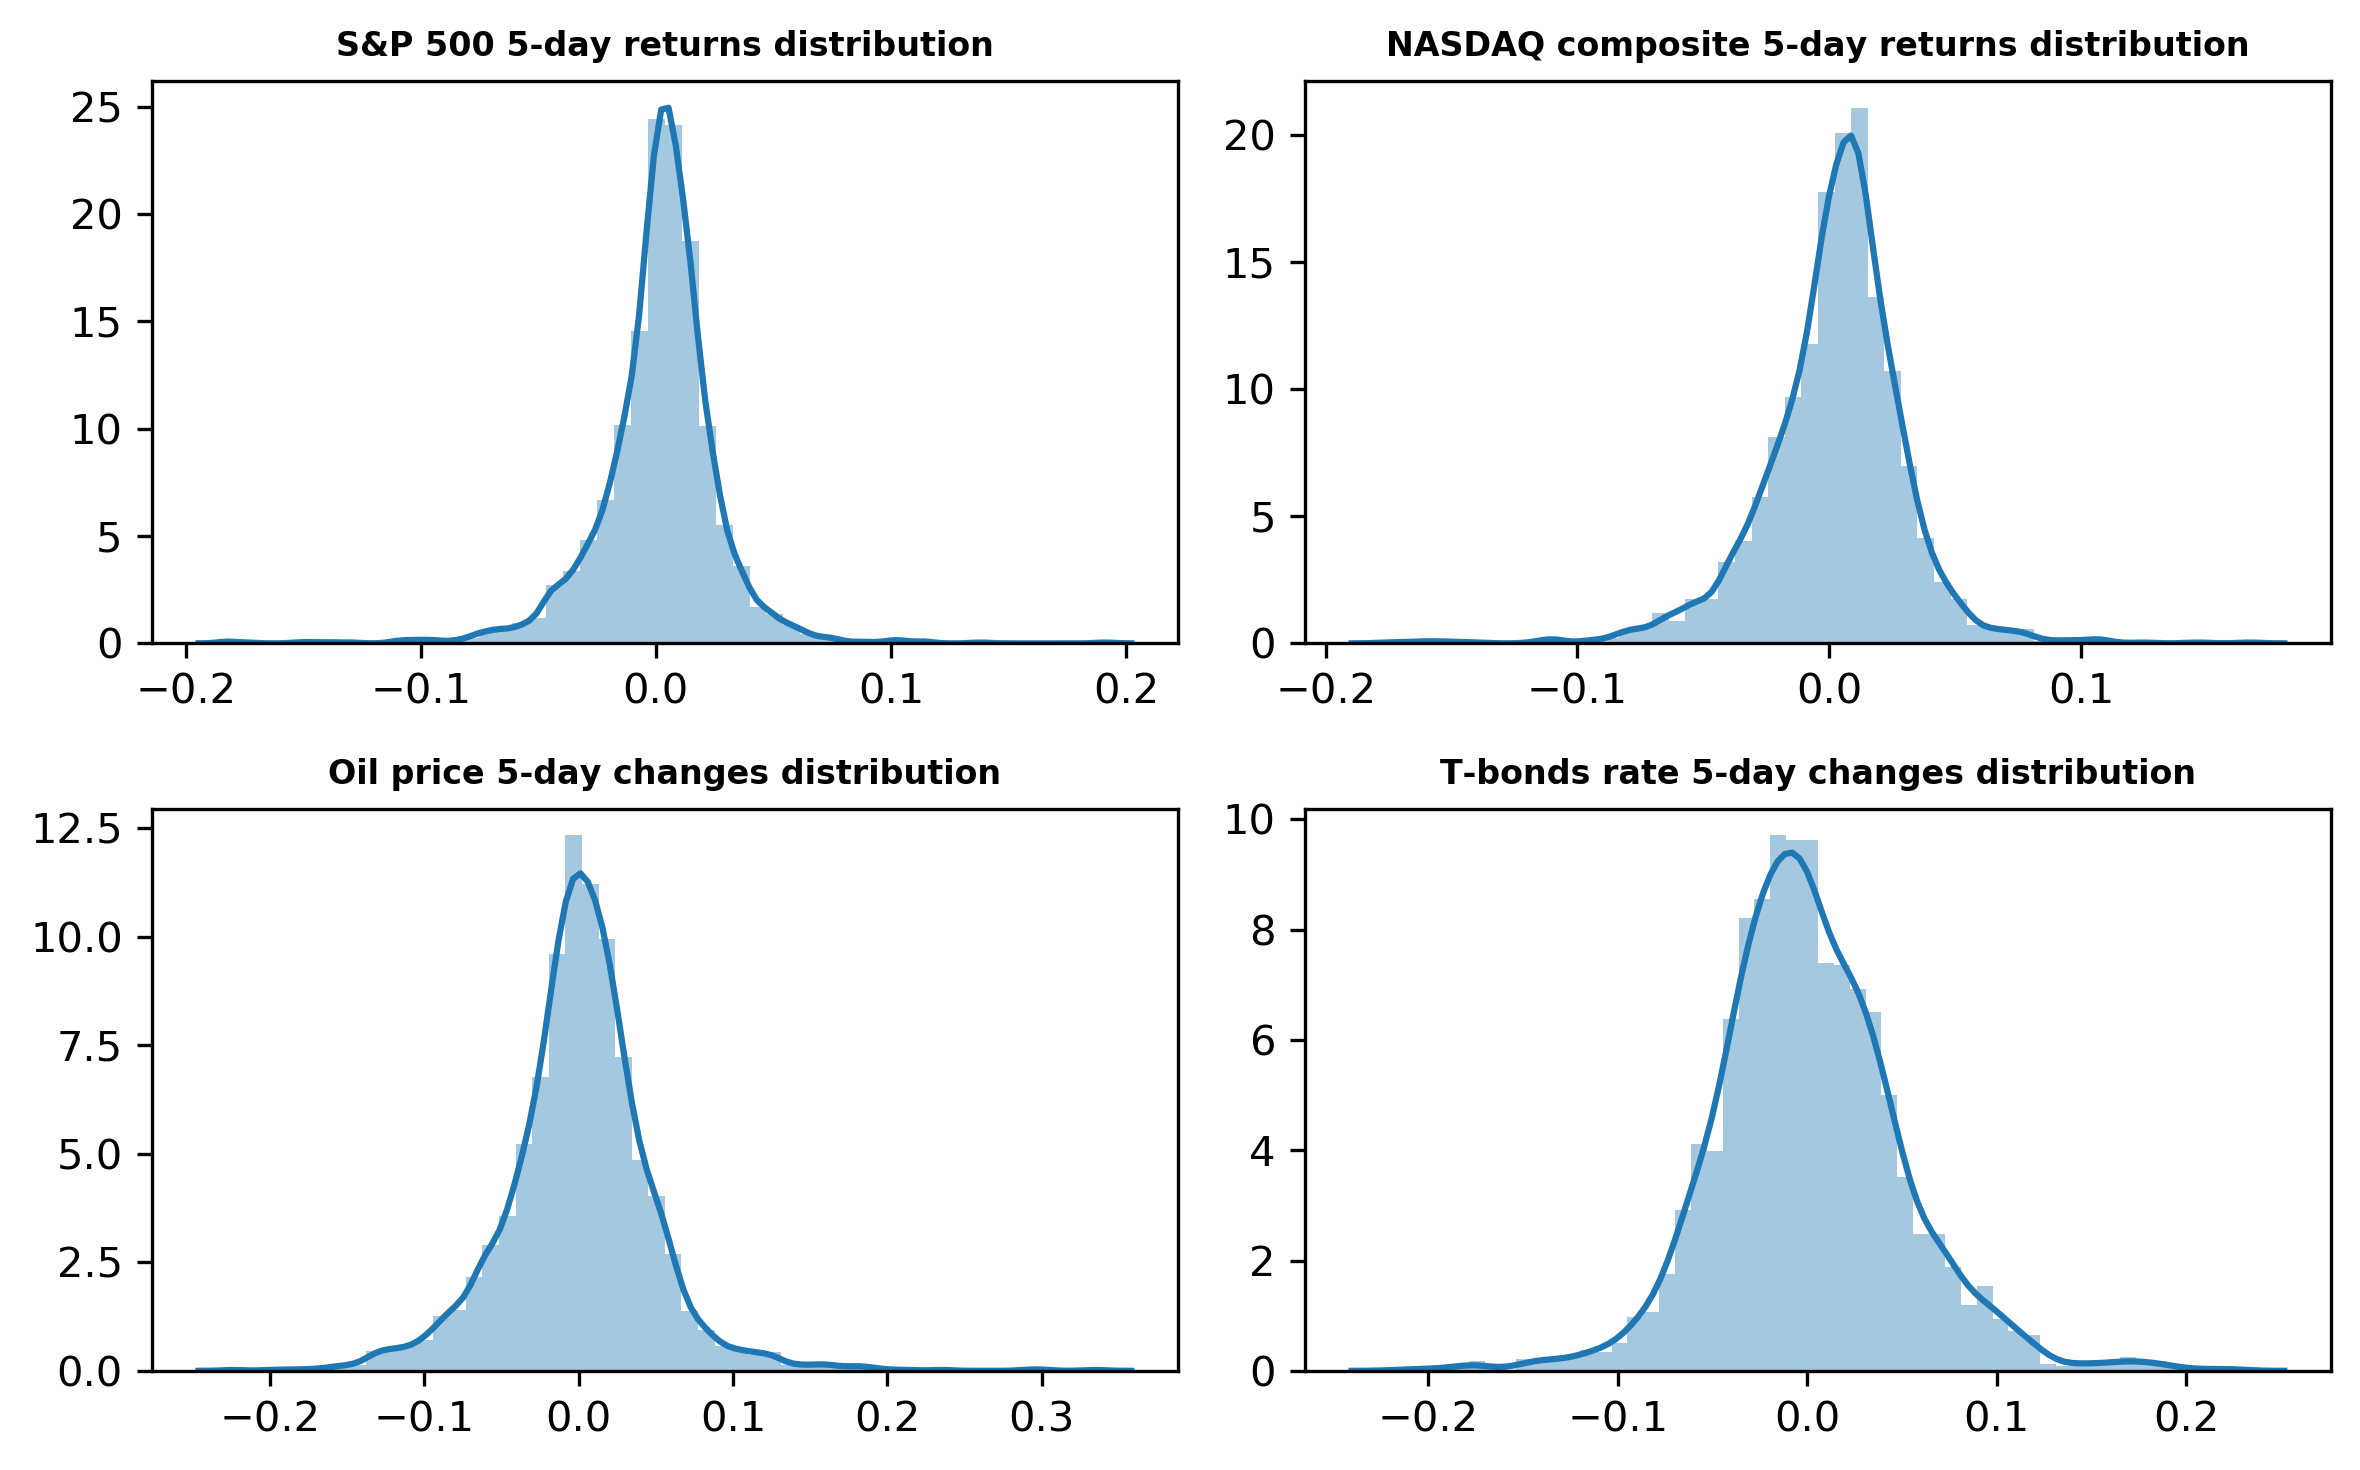

In [7]:
factors_fig = plt.figure(figsize = (8,5), dpi = 300)
factors_titlesize = 8
factors_bins = int(np.sqrt(len(factors_data)))

factors_ax1 = factors_fig.add_subplot(221)
factors_ax1.set_title('S&P 500 5-day returns distribution', weight = 'bold', size = factors_titlesize)
sns.distplot(factors_data.sp500, bins = factors_bins, axlabel = False, ax = factors_ax1)

factors_ax2 = factors_fig.add_subplot(222)
factors_ax2.set_title('NASDAQ composite 5-day returns distribution', weight = 'bold', size = factors_titlesize)
sns.distplot(factors_data.nasdaq, bins = factors_bins, axlabel = False, ax = factors_ax2)

factors_ax3 = factors_fig.add_subplot(223)
factors_ax3.set_title('Oil price 5-day changes distribution', weight = 'bold', size = factors_titlesize)
sns.distplot(factors_data.oil_price, bins = factors_bins, axlabel = False, ax = factors_ax3)

factors_ax4 = factors_fig.add_subplot(224)
factors_ax4.set_title('T-bonds rate 5-day changes distribution', weight = 'bold', size = factors_titlesize)
sns.distplot(factors_data.tbonds_rate, bins = factors_bins, axlabel = False, ax = factors_ax4)

factors_fig.tight_layout()
factors_fig.show()

### 3.2. Monte Carlo simulation of factors' changes
At this step we simulate the values of macroeconomic factors using the multivariate normal distribution.

In [8]:
# Compute the covariance matrix and mean values of factors. These are the inputs we need for the distribution.
covariance_matrix = factors_data.cov()
factors_mean_values = factors_data.mean(axis = 0)

print("Covariance matrix of factors changes:")
display(covariance_matrix)
print('')
print("Mean values of factors changes:")
display(factors_mean_values)

# Perform Monte Carlo simulation
random_factors_array = np.random.multivariate_normal(factors_mean_values, covariance_matrix, size = 10000)

# Create 2 dataframes, which will be used as arrays of features in our ML models predictions.
# First, just the factors' returns simulated
lf_random_factors = pd.DataFrame(random_factors_array)
# Second, factors' returns simulated PLUS their squares
sf_random_factors = pd.concat([lf_random_factors, lf_random_factors ** 2], axis = 1)

print('Sumulation result: factors changes values (first 4 columns), and their squares (last 4 columns)')
display(sf_random_factors.head())

Covariance matrix of factors changes:


,sp500,nasdaq,oil_price,tbonds_rate
sp500,0.000631,0.000670,0.000458,0.000453
nasdaq,0.000670,0.000777,0.000471,0.000500
oil_price,0.000458,0.000471,0.002215,0.000647
tbonds_rate,0.000453,0.000500,0.000647,0.002385



Mean values of factors changes:


sp500          0.001371
nasdaq         0.002147
oil_price      0.000394
tbonds_rate    0.000413
dtype: float64

Sumulation result: factors changes values (first 4 columns), and their squares (last 4 columns)


,0,1,2,3,0,1,2,3
0,0.057104,0.070335,0.079545,0.022205,0.003261,0.004947,0.006327,0.000493
1,-0.016121,-0.022756,-0.063523,0.075167,0.000260,0.000518,0.004035,0.005650
2,-0.013649,-0.007349,-0.068125,-0.006666,0.000186,0.000054,0.004641,0.000044
3,0.018161,0.021178,0.008176,0.059012,0.000330,0.000449,0.000067,0.003482
4,-0.033232,-0.029906,0.006707,0.040424,0.001104,0.000894,0.000045,0.001634


## Step 4. Predicting portfolio returns
### 4.1. Predicting individual stocks returns

In [9]:
def predict_10000_returns_for_stock(symbol):
    """This function takes a symbol as a parameter, and returns and array of 10,000 predicted 5-day returns,
    based a linear regression models which provided a better cross-validated result for this specific stock."""

    # Collect the target variable – 5-day returns of a given stock
    symbol_df = stocks_data[[symbol]]

    """Model 1: only 4 standard features"""
    # Prepare the dataframe of features
    lf_factors_df = factors_data.copy()
    # Merge it to the target variable, match by date
    lf_symbol_with_factors_df = symbol_df.merge(lf_factors_df, on = 'date', how = 'inner')
    # Remove rows where any of columns has NaNs – it's a requirement of sklearn
    lf_symbol_with_factors_df.dropna(inplace = True)
    # Specify the y and X of the regression
    lf_y = lf_symbol_with_factors_df.iloc[:,0]
    lf_X = lf_symbol_with_factors_df.iloc[:,1:]
    
    # Create a model and test it with cross-validation. We DO NOT FIT IT YET.
    lf_lr = LinearRegression()
    lf_cv_scores = cross_val_score(lf_lr, lf_X, lf_y, cv = 4, scoring = 'r2')
    lf_cv_score = np.mean(lf_cv_scores)

    """Model 2: 4 standard features + their squares"""
    # Prepare the dataframe of features and their squares
    sf_factors_df = factors_data.copy()
    sf_symbol_with_factors_df = symbol_df.merge(sf_factors_df, on = 'date', how = 'inner') 
    sf_symbol_with_factors_df = sf_symbol_with_factors_df.merge(sf_factors_df ** 2, on = 'date', how = 'inner') 
    # Remove rows where any of columns has NaNs – it's a requirement of sklearn
    sf_symbol_with_factors_df.dropna(inplace = True)
    # Specify the y and X of the regression
    sf_y = sf_symbol_with_factors_df.iloc[:,0]
    sf_X = sf_symbol_with_factors_df.iloc[:,1:]

    # Create a model and test it with cross-validation. We DO NOT FIT IT YET.
    sf_lr = LinearRegression()
    sf_cv_scores = cross_val_score(sf_lr, sf_X, sf_y, cv = 4, scoring = 'r2')
    sf_cv_score = np.mean(sf_cv_scores)
    
    # If a model with linear features was better, use it
    if (lf_cv_score >= sf_cv_score):
        lf_lr.fit(lf_X, lf_y)
        predicted_returns = lf_lr.predict(lf_random_factors)
    
    # If a model with linear + squared features was better, use it
    else:
        sf_lr.fit(sf_X, sf_y)
        predicted_returns = sf_lr.predict(sf_random_factors)
        
    return predicted_returns

### 4.2. Calculating the current portfolio value and stocks' weights
Here we use the assumption given in class: we own 1 unit of stock in each security.
Therefore, the weights of stocks are just proportional to their prices.

In [10]:
# Get prices for all stocks only
stocks_prices = all_data_prices[stocks_columns]

# Initialize a dictionary to store symbols as keys, and last available prices as values 
dictionary_of_prices = {}

# For each stock, find the latest available (non-NaN) price and add it to the dictionary
for symbol in stocks_columns:
    series = stocks_prices[symbol]
    series.dropna(inplace = True)
    last_price = series[-1]
    
    dictionary_of_prices[symbol] = last_price

# Calculate the sum of prices - it will be the denominator in weights' calculation
sum_of_prices = sum(dictionary_of_prices.values())

# Create a dictionary where symbols are keys, and their weights in the portfolio are values.
dictionary_of_weights = {}

for symbol in dictionary_of_prices:
    dictionary_of_weights[symbol] = dictionary_of_prices[symbol] / sum_of_prices
    
print('Dictionary of prices:')
print(dictionary_of_prices)
print('')
print('Dictionary of weights:')
print(dictionary_of_weights)

Dictionary of prices:
{'AAON': 37.4064, 'BCOM': 4.3, 'BOSC': 2.5652, 'CFFI': 48.448, 'CHOP': 0.65, 'CHRW': 85.8278, 'CRMT': 69.92, 'DGLD': 44.01, 'DJCO': 224.2, 'DOX': 55.2203, 'EGHT': 18.43, 'FCCY': 18.8269, 'FLWS': 17.3, 'FOLD': 12.07, 'FTLB': 20.5602, 'FUBC': 8.85, 'GOOG': 1132.8, 'HGSH': 0.996, 'HTHT': 33.511, 'IMOS': 15.947, 'INBK': 20.5837, 'JOBS': 71.58, 'JRJC': 10.5, 'KOOL': 3.7, 'MTGE': 19.8, 'PIH': 4.503, 'PLCE': 88.9617, 'QABA': 47.3725, 'SATS': 21.1134, 'SRCE': 44.9565, 'TWOU': 59.19, 'UHAL': 360.8754, 'VNET': 9.26, 'WATT': 7.67}

Dictionary of weights:
{'AAON': 0.014266878471950739, 'BCOM': 0.0016400289102770696, 'BOSC': 0.0009783725954983114, 'CFFI': 0.018478167591884528, 'CHOP': 0.00024791134690234774, 'CHRW': 0.03273490076871588, 'CRMT': 0.026667632885249468, 'DGLD': 0.016785505195649728, 'DJCO': 0.0855103445777021, 'DOX': 0.021061136845156484, 'EGHT': 0.0070292401898619525, 'FCCY': 0.0071806186723012465, 'FLWS': 0.006598255848324025, 'FOLD': 0.004603523010940519, 'FTLB

/Users/urij/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4784: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


### 4.3. Predicting the whole portfolio returns and value in 5 days period
The return of the whole portfolio is the weighted average return of securities included in it, where weights are proportions of values of specific securities in the whole portfolio value.
Therefore, the portfolio overall return can be computed as the sum of products of individual returns and weights.

/Users/urij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


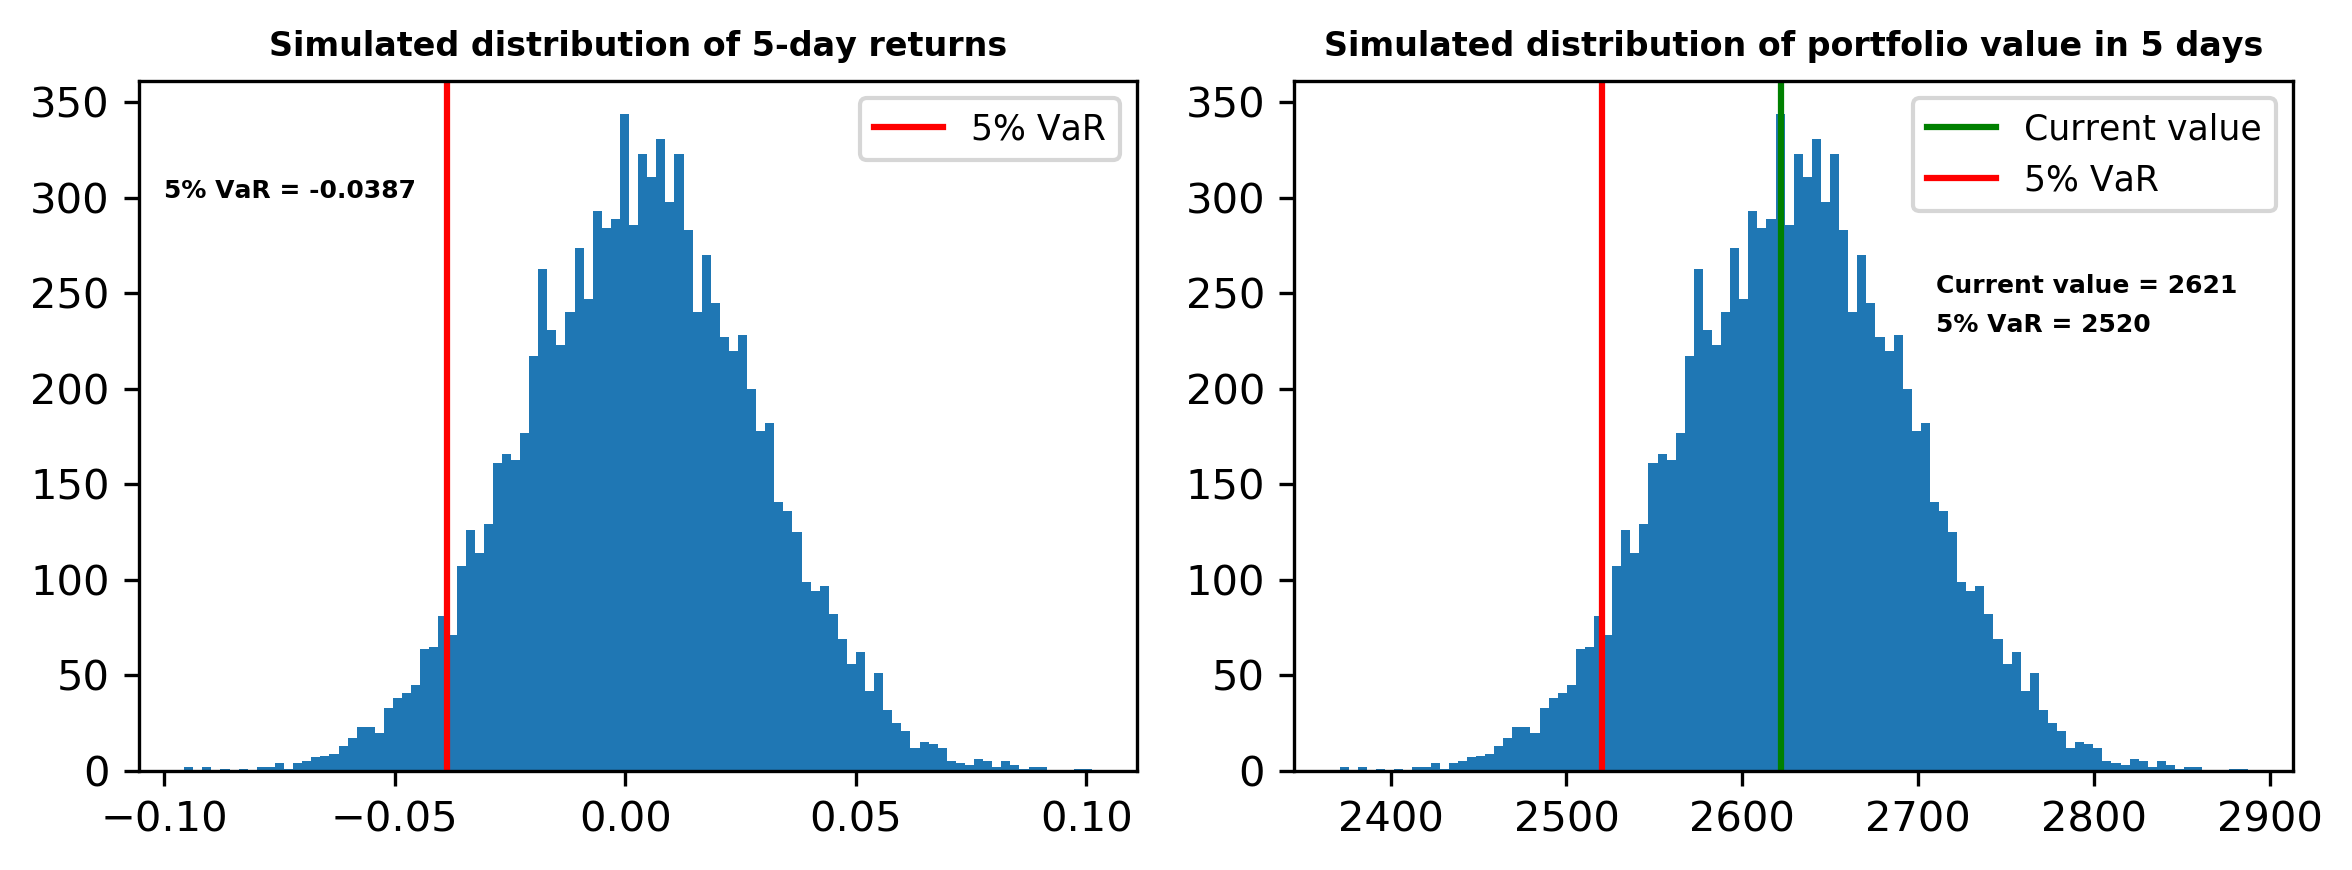

In [13]:
# Initialize an array of zeros - it will act as a container to accumulate sum of products described above
simulated_returns = np.zeros(10000)

# For each symbol of stock...
for symbol in stocks_columns:
    # Predict returns
    predicted_returns = predict_10000_returns_for_stock(symbol)
    # Multiply them by weight of this stock in the portfolio
    weighted_returns = predicted_returns * dictionary_of_weights[symbol]
    # Add to our container
    simulated_returns += weighted_returns
    # In the end of this loop, our container holds the simulated portfolio returns
    
# Calculate the 5% VaR of return
var_return = np.quantile(simulated_returns, 0.05)

# Bring the current portfolio value, and use it to calculate the portfolio value distibution in 5 days
current_portfolio_value = sum_of_prices
portfolio_value_in_5_days = (1 + simulated_returns) * current_portfolio_value

# Calculate the 5% VaR of value
var_value = np.quantile(portfolio_value_in_5_days, 0.05)

# The last part is just provisioning a chart
results_fig = plt.figure(figsize = (8,3), dpi = 300)
results_titlesize = 8
results_bins = int(np.sqrt(10000))

results_ax1 = results_fig.add_subplot(121)
results_ax1.set_title('Simulated distribution of 5-day returns', weight = 'bold', size = results_titlesize)
results_ax1.hist(simulated_returns, bins = results_bins)
results_ax1.axvline(var_return, color = 'red', label = '5% VaR')
results_ax1.legend(loc=0, fontsize='small')
results_ax1.text(-0.1, 300, '5% VaR = ' + str(np.round(var_return,4)), weight = 'bold', fontsize = 6)

results_ax2 = results_fig.add_subplot(122)
results_ax2.set_title('Simulated distribution of portfolio value in 5 days', weight = 'bold', size = results_titlesize)
results_ax2.hist(portfolio_value_in_5_days, bins = results_bins)
results_ax2.axvline(current_portfolio_value, color = 'green', label = 'Current value')
results_ax2.axvline(var_value, color = 'red', label = '5% VaR')
results_ax2.legend(loc=0, fontsize='small')
results_ax2.text(2710, 250, 'Current value = ' + str(int(current_portfolio_value)), weight = 'bold', fontsize = 6)
results_ax2.text(2710, 230, '5% VaR = ' + str(int(var_value)), weight = 'bold', fontsize = 6)

results_fig.tight_layout()
results_fig.show()

Please, note that the green line in the right chart in NOT the expected value of the simulated distribution, which is plotted by the histogram. It's a current portfolio value.